# 強化学習の目的は「最善の方策（**Policy**）」の作成

### FrozenLake-v1（4x4）

<img src='./image/Frozen-Lake.png' width='300'>

**ゲームのルール**
- S（Start）から始まり
- G（Goal）に向かい
- H（Hole）に落ちないよう
- F（Frozen）な床を踏みながら進みます


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

SEED = 52

# FrozenLake 環境の初期化（滑らない）
env = gym.make("FrozenLake-v1", is_slippery=False)
n_states = env.observation_space.n
n_actions = env.action_space.n

In [2]:
def show_policy_grid(pi, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    for i in range(4):
        for j in range(4):
            ax.text(j + 0.5, 3.5 - i, pi[i, j], ha='center', va='center', fontsize=16)
            ax.add_patch(plt.Rectangle((j, 3 - i), 1, 1, fill=False, edgecolor='black'))
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()

# 報酬・regretのプロット
def plot_reward_regret(rewards, label):
    rewards = np.array(rewards)
    regrets = 1 - rewards
    window = 100
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        moving_regret = np.convolve(regrets, np.ones(window)/window, mode='valid')
        plt.plot(moving_avg, label=f'{label} (reward)')
        plt.plot(moving_regret, linestyle='--', label=f'{label} (regret)')

# 報酬のプロット
def plot_reward_only(rewards, label):
    rewards = np.array(rewards)
    regrets = 1 - rewards
    window = 100
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        moving_regret = np.convolve(regrets, np.ones(window)/window, mode='valid')
        plt.plot(moving_avg, label=f'{label} (reward)')
#        plt.plot(moving_regret, linestyle='--', label=f'{label} (regret)')

def initial_policy():
    # 完全ランダムな Q（値は全てゼロ）
    Q_dummy = np.zeros((n_states, n_actions))

    # ε = 1.0 のランダム方策を各状態で決定（1回限りなので再現性は低い）
    random_policy = np.array([epsilon_greedy(Q_dummy, s, epsilon=1.0) for s in range(n_states)])
    
    # 記号に変換して reshape（4x4 グリッド用）
    arrow_map = ['←', '↓', '→', '↑']
    pi_random = np.array([arrow_map[a] for a in random_policy]).reshape(4, 4)
    
    # グリッドで表示
    show_policy_grid(pi_random, "Initial Random Policy (ε=1.0)")

## 初期方策: Initial Policy

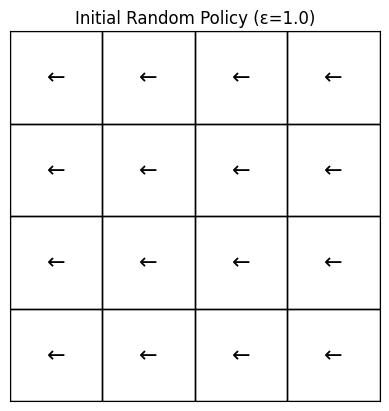

In [3]:
# 完全ランダムな Q（値は全てゼロ）
Q_dummy = np.zeros((n_states, n_actions))

# ε = 1.0 のランダム方策を各状態で決定（1回限りなので再現性は低い）
#random_policy = np.array([epsilon_greedy(Q_dummy, s, epsilon=1.0) for s in range(n_states)])
random_policy = policy = np.zeros(env.observation_space.n, dtype=int)

# 記号に変換して reshape（4x4 グリッド用）
arrow_map = ['←', '↓', '→', '↑']
pi_random = np.array([arrow_map[a] for a in random_policy]).reshape(4, 4)

# グリッドで表示
show_policy_grid(pi_random, "Initial Random Policy (ε=1.0)")

## Monte Carlo, SARSA, Q-learning 比較

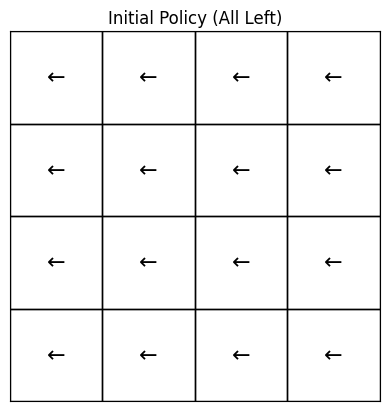

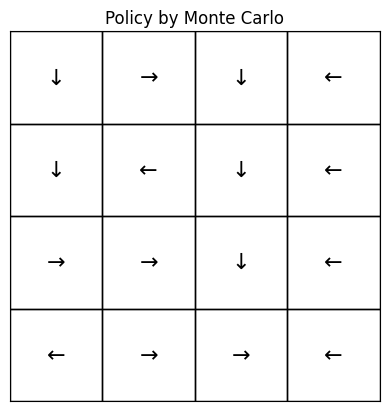

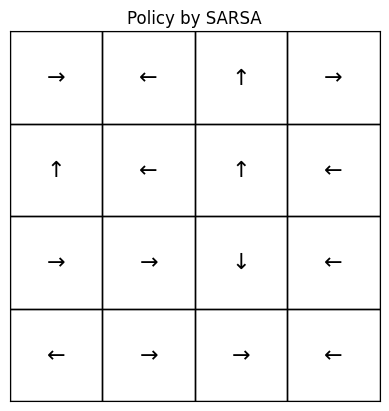

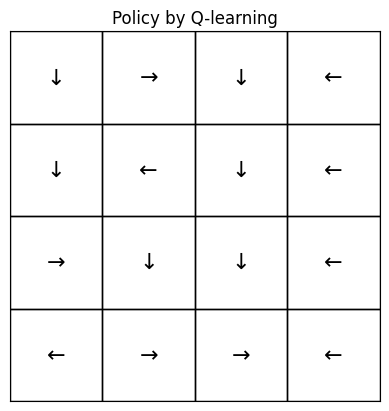

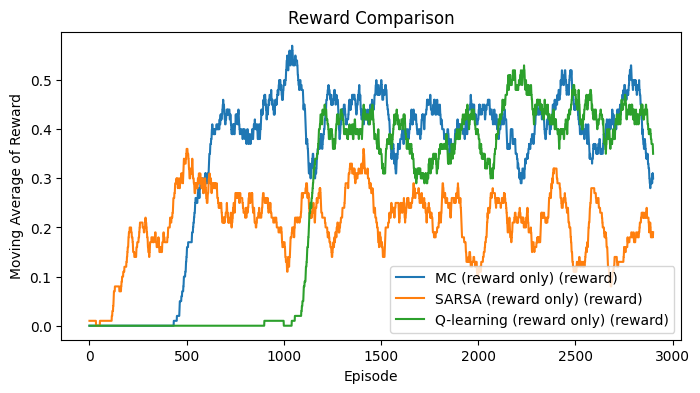

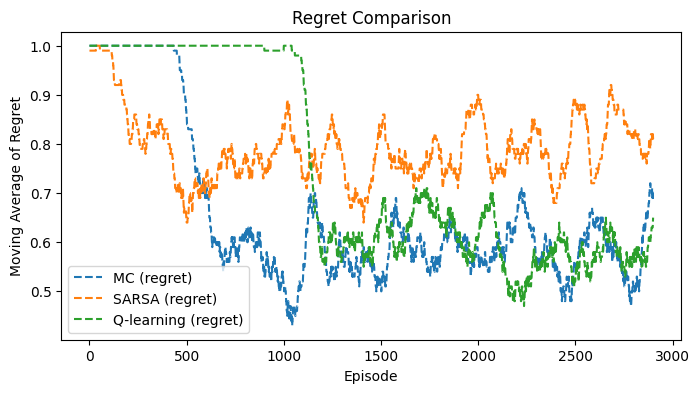

In [4]:
# ハイパーパラメータ
gamma = 0.99
alpha = 0.8
epsilon = 0.5 #0.3
episodes = 3000

# ε-greedy 方策
def epsilon_greedy(Q, s, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[s])

# Monte Carlo 法
def run_mc():
    Q = np.zeros((n_states, n_actions))
    returns = { (s,a): [] for s in range(n_states) for a in range(n_actions) }
    rewards = []
    for _ in range(episodes):
        trajectory = []
        s, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            a = epsilon_greedy(Q, s, epsilon)
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            trajectory.append((s, a, r))
            s = s_next
            total_reward += r
        rewards.append(total_reward)
        G = 0
        visited = set()
        for s, a, r in reversed(trajectory):
            G = gamma * G + r
            if (s, a) not in visited:
                returns[(s,a)].append(G)
                Q[s,a] = np.mean(returns[(s,a)])
                visited.add((s, a))
    return Q, rewards

# SARSA 法
def run_sarsa():
    Q = np.zeros((n_states, n_actions))
    rewards = []
    for _ in range(episodes):
        s, _ = env.reset()
        a = epsilon_greedy(Q, s, epsilon)
        done = False
        total_reward = 0
        while not done:
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            a_next = epsilon_greedy(Q, s_next, epsilon)
            Q[s, a] += alpha * (r + gamma * Q[s_next, a_next] - Q[s, a])
            s, a = s_next, a_next
            total_reward += r
        rewards.append(total_reward)
    return Q, rewards

# Q-learning 法
def run_q_learning():
    Q = np.zeros((n_states, n_actions))
    rewards = []
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            a = epsilon_greedy(Q, s, epsilon)
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            Q[s, a] += alpha * (r + gamma * np.max(Q[s_next]) - Q[s, a])
            s = s_next
            total_reward += r
        rewards.append(total_reward)
    return Q, rewards

# 方策可視化
arrow_map = ['←', '↓', '→', '↑']
def policy_from_q(Q):
    return np.array([arrow_map[np.argmax(Q[s])] for s in range(n_states)]).reshape(4, 4)

def left_policy():
    return np.array([arrow_map[0] for _ in range(n_states)]).reshape(4, 4)    
    
def initial_left_policy():
    pi_left = np.array([arrow_map[0] for _ in range(n_states)]).reshape(4, 4)
    show_policy_grid(pi_left, "Initial Policy (All Left)")

initial_left_policy()

# 学習実行と可視化
Q_mc, rewards_mc = run_mc()
Q_sarsa, rewards_sarsa = run_sarsa()
Q_q, rewards_q = run_q_learning()

# initial_policy()
# print("##########################################################")

# 方策表示
show_policy_grid(policy_from_q(Q_mc), "Policy by Monte Carlo")
show_policy_grid(policy_from_q(Q_sarsa), "Policy by SARSA")
show_policy_grid(policy_from_q(Q_q), "Policy by Q-learning")

# # 報酬・regretグラフ
# plot_reward_regret(rewards_mc, "MC")
# plot_reward_regret(rewards_sarsa, "SARSA")
# plot_reward_regret(rewards_q, "Q-learning")
# plt.xlabel("Episode")
# plt.ylabel("Moving Average")
# plt.title("Reward and Regret Comparison")
# plt.legend()
# plt.show()

# # --- reward_Reward グラフ ---
# plt.figure(figsize=(8, 4))
# plot_reward_regret(rewards_mc, "MC (reward only)")
# plot_reward_regret(rewards_sarsa, "SARSA (reward only)")
# plot_reward_regret(rewards_q, "Q-learning (reward only)")
# plt.xlabel("Episode")
# plt.ylabel("Moving Average of Reward")
# plt.title("Reward Comparison")
# plt.legend()
# plt.show()

# --- Reward グラフ ---
plt.figure(figsize=(8, 4))
plot_reward_only(rewards_mc, "MC (reward only)")
plot_reward_only(rewards_sarsa, "SARSA (reward only)")
plot_reward_only(rewards_q, "Q-learning (reward only)")
plt.xlabel("Episode")
plt.ylabel("Moving Average of Reward")
plt.title("Reward Comparison")
plt.legend()
plt.show()


# --- Regret グラフ ---
def plot_regret_only(rewards, label):
    regrets = 1 - np.array(rewards)
    window = 100
    if len(regrets) >= window:
        moving_regret = np.convolve(regrets, np.ones(window)/window, mode='valid')
        plt.plot(moving_regret, linestyle='--', label=f'{label} (regret)')

plt.figure(figsize=(8, 4))
plot_regret_only(rewards_mc, "MC")
plot_regret_only(rewards_sarsa, "SARSA")
plot_regret_only(rewards_q, "Q-learning")
plt.xlabel("Episode")
plt.ylabel("Moving Average of Regret")
plt.title("Regret Comparison")
plt.legend()
plt.show()

## 考察

**1. 学習開始が極端に遅い（Reward/Regret ともに）**
- MCやQ-learningが早期に学習を開始
- SARSAは エピソード1000以降で reward > 0

SARSA は初期方策に強く引きずられ「安全な行動に留まる」傾向

**2. 学習後の性能も他より劣る（Reward < 0.3, Regret > 0.7）**
- Q-learningやMCは reward 0.45〜0.5 前後で安定
- SARSAは reward が 0.25前後で頭打ち
- regret も最小で 0.7付近と高いまま

**3. 「SARSAの哲学的な限界」**
- SARSAは実際に取った行動を使って更新（**オンポリシー**）
- ε-greedyの ε を下げすぎると、悪い方策に固執しやすくなる
- 「現場主義・慎重・方策忠実」だが「グローバル最適にたどり着きにくい」